# Week 2

In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import janitor
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,6)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Optional: For higher quality plots

alt.renderers.enable('default')
alt.renderers.set_embed_options(width=1000)

RendererRegistry.enable('default')

In [174]:
dat = pd.read_csv("data/data.csv", parse_dates=['Date']).clean_names()
dat

,date,company_sales,product_sales
0,2019-01-01,1500.0,8
1,2019-02-01,2600.0,0
2,2019-03-01,2000.0,14
3,2019-04-01,2700.0,0
4,2019-05-01,3000.0,3
...,...,...,...
1091,2021-12-27,5550.0,41
1092,2021-12-28,1648.0,3
1093,2021-12-29,1424.0,19
1094,2021-12-30,6076.0,0


## Exercise A

**Exercise A**. The first series of the dataset presents the daily sales of a retail store, expressed in Euros. You are asked:
  - To visualize the original series.
  - To identify the missing values and fill them using an appropriate method.
  - To identify the outliers present and normalize their values.
  - To create and visualize the respective weekly and monthly series.
  - To decompose the monthly series and visualize its trend and seasonal components.
  - To compute the average sales per weekday and month.

### Daily Sales Time Series

In [175]:
alt.Chart(dat).\
    mark_line(point=alt.OverlayMarkDef(filled=False, fill="white")).\
        encode(x = 'date:T', y = 'company_sales:Q', tooltip=['date', 'company_sales']).\
            interactive()

alt.Chart(...)

### Missing Values

There are some missing values here.

In [176]:
dat[dat.company_sales.isna()]

,date,company_sales,product_sales
85,2019-03-27,NaN,0
87,2019-03-29,NaN,0
88,2019-03-30,NaN,0
89,2019-03-31,NaN,0
125,2019-06-05,NaN,0
127,2019-08-05,NaN,0
131,2019-12-05,NaN,0
173,2019-06-23,NaN,0
177,2019-06-27,NaN,0
214,2019-03-08,NaN,0


Using a linear interpolation to fill these values.

In [177]:
dat.set_index('date', inplace=True)
dat.interpolate(method="linear", inplace=True)
assert dat.isnull().sum().sum() == 0

### Outliers

One way we could identify outliers is using a lower 2.5th and upper 97.5th percentile to identify points.

In [178]:
def outliers_by_quantiles(df, columns):
    for column in columns:
        quantile_5 = df[column].quantile(0.025)
        quantile_95 = df[column].quantile(0.975)
        
        df[column + '_outlier'] = df[column].apply(lambda x: True if x < quantile_5 or x > quantile_95 else False)

    return df

dat = outliers_by_quantiles(dat, ['company_sales'])
dat

,company_sales,product_sales,company_sales_outlier
date,,,
2019-01-01,1500.0,8,False
2019-02-01,2600.0,0,False
2019-03-01,2000.0,14,False
2019-04-01,2700.0,0,False
2019-05-01,3000.0,3,False
...,...,...,...
2021-12-27,5550.0,41,True
2021-12-28,1648.0,3,False
2021-12-29,1424.0,19,False


In [179]:
def tplot(df):
    line = alt.Chart(df.reset_index()).\
    mark_line().\
    encode(x = 'date:T', y = 'company_sales:Q', tooltip=['date', 'company_sales', 'company_sales_outlier'])
            
    points = alt.Chart(df.reset_index()).\
        mark_point().\
        encode(x = 'date:T', y = 'company_sales:Q', color='company_sales_outlier', fill='company_sales_outlier', tooltip=['date', 'company_sales', 'company_sales_outlier'])
        
    return (line + points).interactive()

def lplot(df):
    line = alt.Chart(df.reset_index()).\
        mark_line().\
        encode(x = 'date:T', y = 'company_sales:Q', tooltip=['date', 'company_sales', 'company_sales_outlier'])

    return (line).interactive()

tplot(dat)

alt.LayerChart(...)

We could "normalize" these values, say, by capping them to the quantile values. Not sure how right it is to do it on these series in this way, but for illustrative purposes, I'll proceeed.

In [180]:
dat.loc[dat.company_sales>dat.company_sales.quantile(0.975), "company_sales"] = dat.company_sales.quantile(0.975)
dat.loc[dat.company_sales<dat.company_sales.quantile(0.025), "company_sales"] = dat.company_sales.quantile(0.025)

tplot(dat)

alt.LayerChart(...)

### Weekly and Monthly Series

One way we could look at the monthly series is by year-month...

In [181]:
monthly = dat.resample('M').mean()
monthly

,company_sales,product_sales,company_sales_outlier
date,,,
2019-01-31,2116.129032,5.483871,0.000000
2019-02-28,2186.406250,5.785714,0.035714
2019-03-31,1782.258065,2.967742,0.000000
2019-04-30,2070.645833,7.233333,0.033333
2019-05-31,2145.786290,2.741935,0.032258
2019-06-30,2158.333333,6.100000,0.000000
2019-07-31,2019.979839,7.096774,0.032258
2019-08-31,1816.129032,5.193548,0.000000
2019-09-30,2103.333333,5.300000,0.000000


In [182]:
lplot(monthly)

alt.Chart(...)

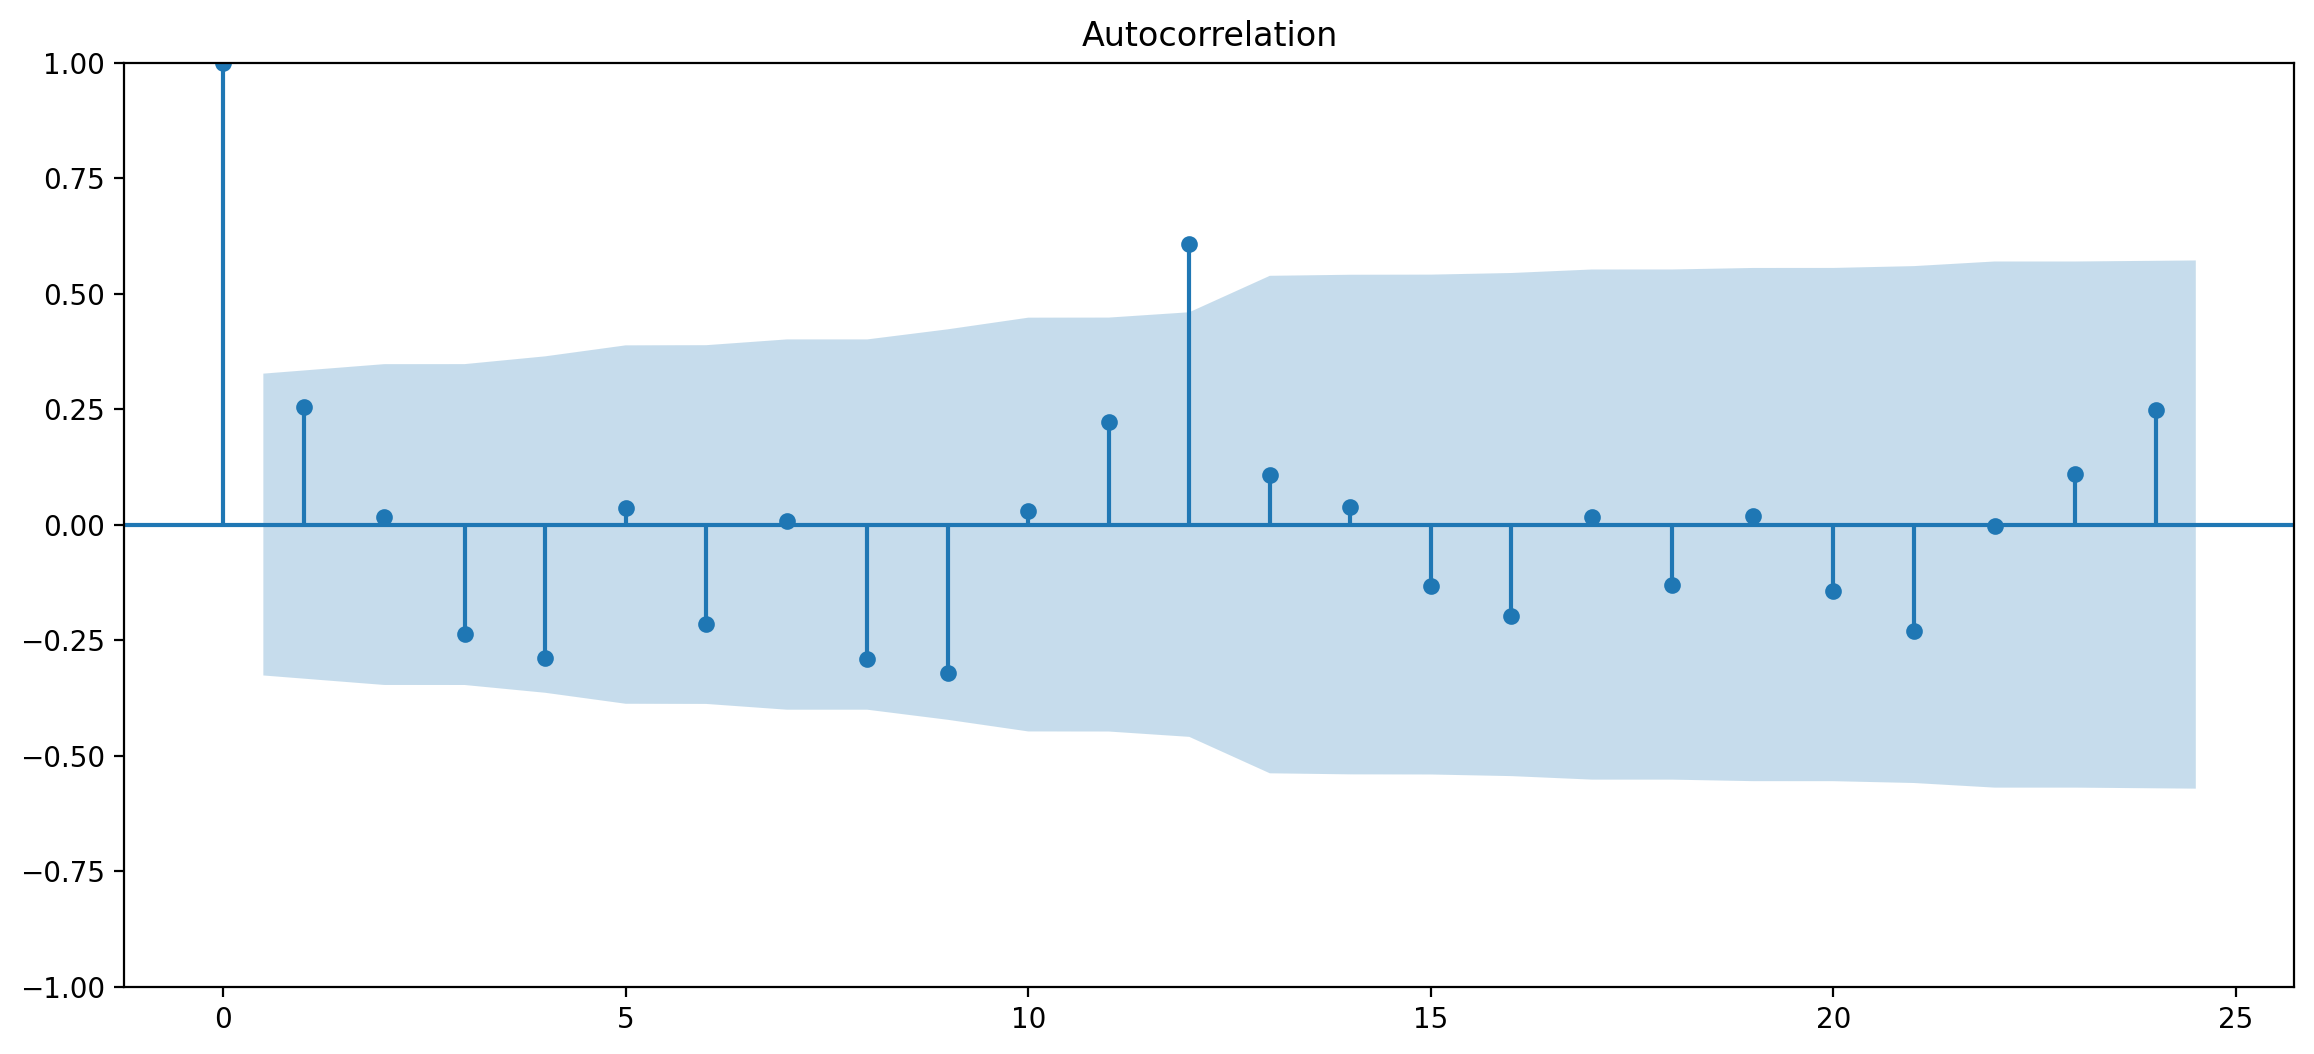

In [183]:
sm.graphics.tsa.plot_acf(monthly.company_sales.squeeze(), lags=12*2);

Another way to look at this data is purely by month

In [184]:
dat['month'] = dat.index.month_name()
mdat = dat.groupby('month').mean().filter(['company_sales'])
alt.Chart(mdat.reset_index()).mark_line(point=True).encode(x = 'month', y = 'company_sales').interactive()

alt.Chart(...)

In [185]:
weekly = dat.resample('W').mean()
lplot(weekly)

/var/folders/py/6q30txtn4sx98k_sxsdqgx4w0000gn/T/ipykernel_75519/2980661144.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly = dat.resample('W').mean()


alt.Chart(...)

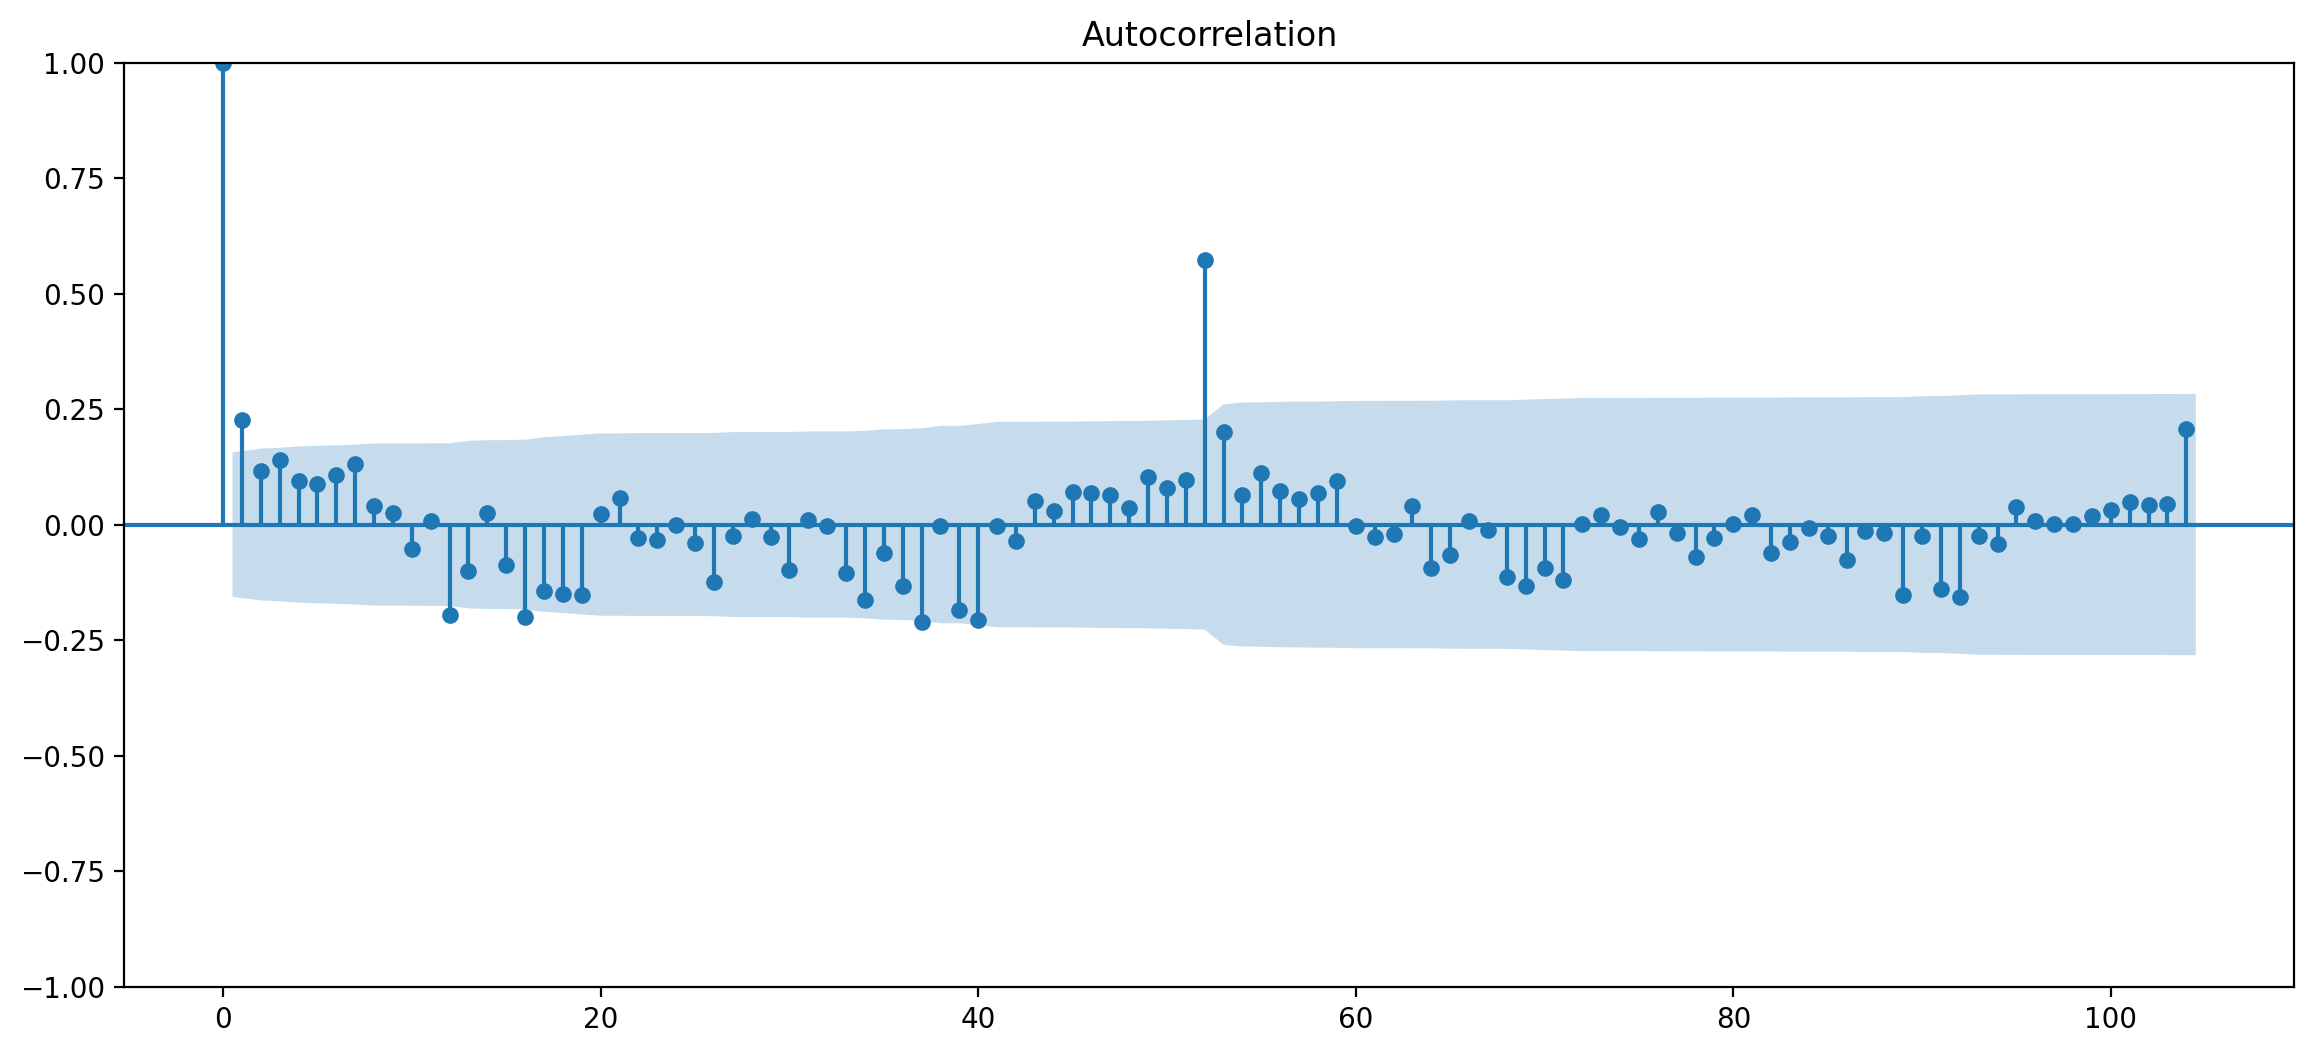

In [186]:
sm.graphics.tsa.plot_acf(weekly.company_sales.squeeze(), lags=52*2);

### Decomposition of Monthly Series

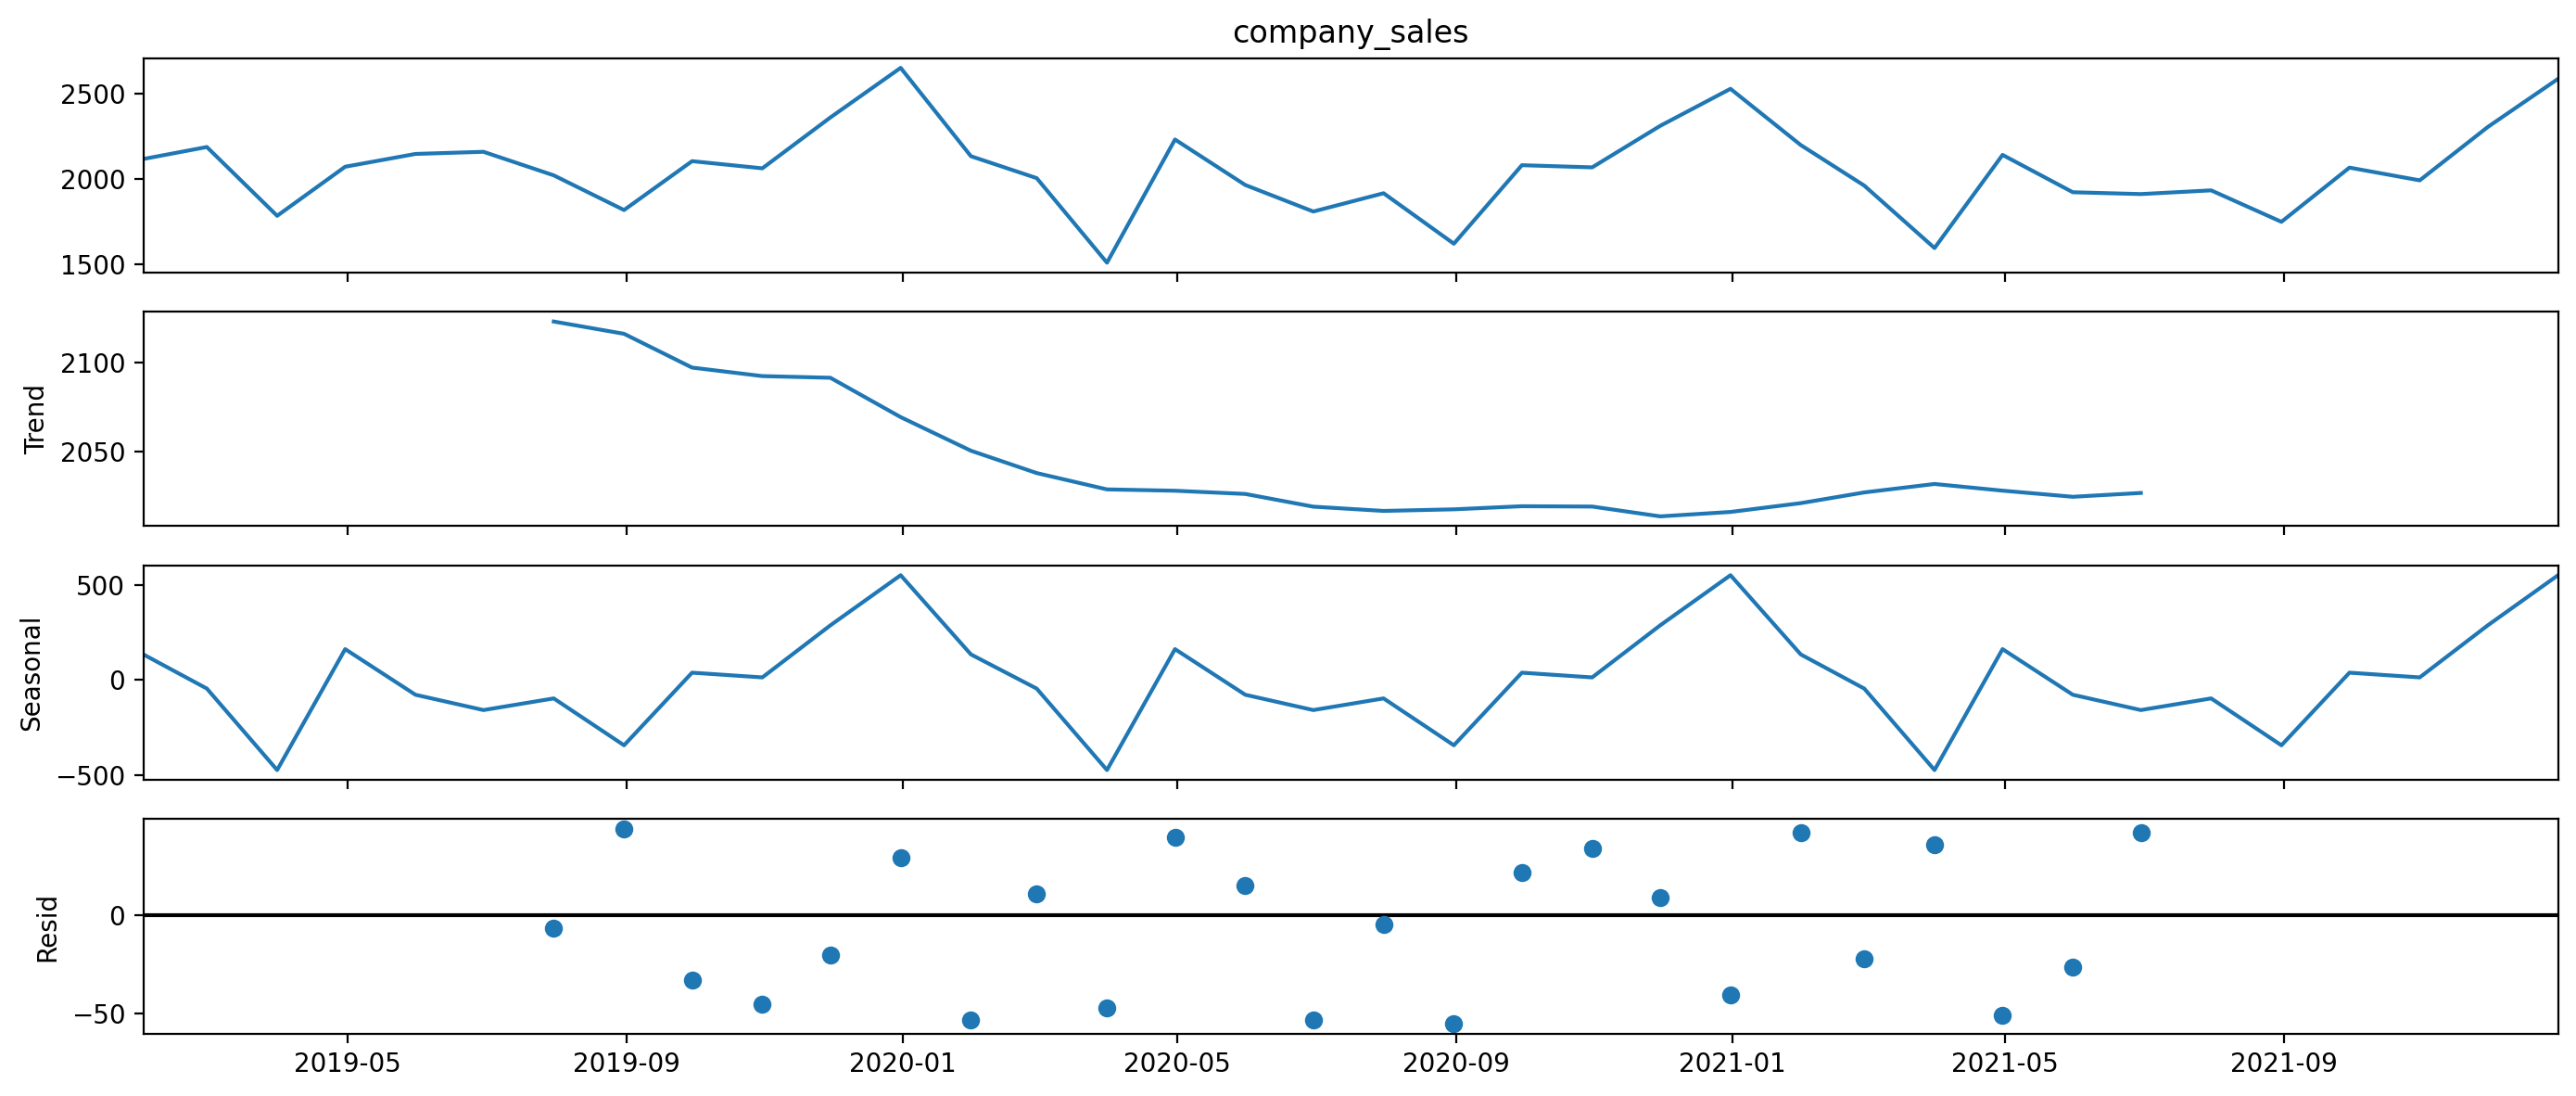

In [187]:
monthly_decompose = seasonal_decompose(monthly.company_sales)
monthly_decompose.plot();

### Average sales per weekday and month

In [188]:
dat \
    .filter(['company_sales']) \
    .groupby(pd.Grouper(freq='B')) \
    .mean()

,company_sales
date,
2019-01-01,1500.000000
2019-01-02,2000.000000
2019-01-03,4200.000000
2019-01-04,1833.333333
2019-01-07,1200.000000
...,...
2021-12-27,4519.375000
2021-12-28,1648.000000
2021-12-29,1424.000000


## Exercise B

**Exercise B**. The second series of the dataset presents the daily sales of a product sold in the store, expressed in units. You are asked:
  - To visualize the series.
  - To compute the average daily demand of the product, the coefficient of variation of non-zero demands (CV2), and the average number of time periods between two successive non-zero demands (ADI).
  -  To visualize the empirical distribution of the demand of the product and compute its 5%, 50% and 95% percentiles.
  -  To create and visualize the respective monthly series and comment on its seasonal pattern, if present.

### Daily Product Sales Series

In [189]:
alt.Chart(dat.reset_index()).\
    mark_line(point=alt.OverlayMarkDef(filled=False, fill="white")).\
        encode(x = 'date:T', y = 'product_sales:Q', tooltip=['date', 'product_sales']).\
            interactive()

alt.Chart(...)

In [214]:
sales = dat.filter(['product_sales']).query('product_sales != 0').reset_index().sort_values('date')
sales["interval"] = sales.date - sales.date.shift(1)
sales

,date,product_sales,interval
0,2019-01-01,8,NaT
15,2019-01-02,12,1 days
26,2019-01-03,4,1 days
37,2019-01-04,8,1 days
56,2019-01-05,8,1 days
...,...,...,...
527,2021-12-26,6,3 days
528,2021-12-27,41,1 days
529,2021-12-28,3,1 days
530,2021-12-29,19,1 days


###  Average daily demand of the product

In [222]:
dat.product_sales.mean()

5.789233576642336

### Coefficient of variation of non-zero demands (CV2)

In [220]:
(np.std(sales.product_sales)/np.mean(sales.product_sales))**2

0.4825663562393773

### Average number of time periods between two successive non-zero demands (ADI)

In [223]:
sales.interval.mean()

Timedelta('2 days 01:29:29.491525423')

### Demand Distribution

In [267]:
density_plot = alt.Chart(sales[['product_sales']]).transform_density('product_sales', as_=['Demand', 'Density'],
                             ).mark_area(color='gray').encode(
    x="Demand:Q",
    y='Density:Q'
)
                             
quantiles = sales['product_sales'].quantile([0.05, 0.5, 0.95]).values

vertical_lines = alt.Chart(pd.DataFrame({'quantiles': quantiles})).mark_rule(color='black').encode(x='quantiles:Q')

labels = pd.DataFrame({'quantiles': quantiles, 'labels': [f'Q{q}' for q in [0.05, 0.5, 0.95]]})

labels_text = alt.Chart(labels).mark_text(dy=-10, color='red').encode(
    x='quantiles:Q',
    y=alt.value(0),
    text='labels:N'
)

# Layer density plot and vertical lines
density_plot + vertical_lines + labels_text

alt.LayerChart(...)

### Seasonality of Monthly series

Looking at these plots, we can identify the seasonality, particularly using the ACF plot.

In [278]:
monthly_sales = dat[['product_sales']].resample("M").mean().reset_index()
monthly_sales.head()

,date,product_sales
0,2019-01-31,5.483871
1,2019-02-28,5.785714
2,2019-03-31,2.967742
3,2019-04-30,7.233333
4,2019-05-31,2.741935


In [282]:
alt.Chart(monthly_sales).mark_line().encode(x="date", y="product_sales")

alt.Chart(...)

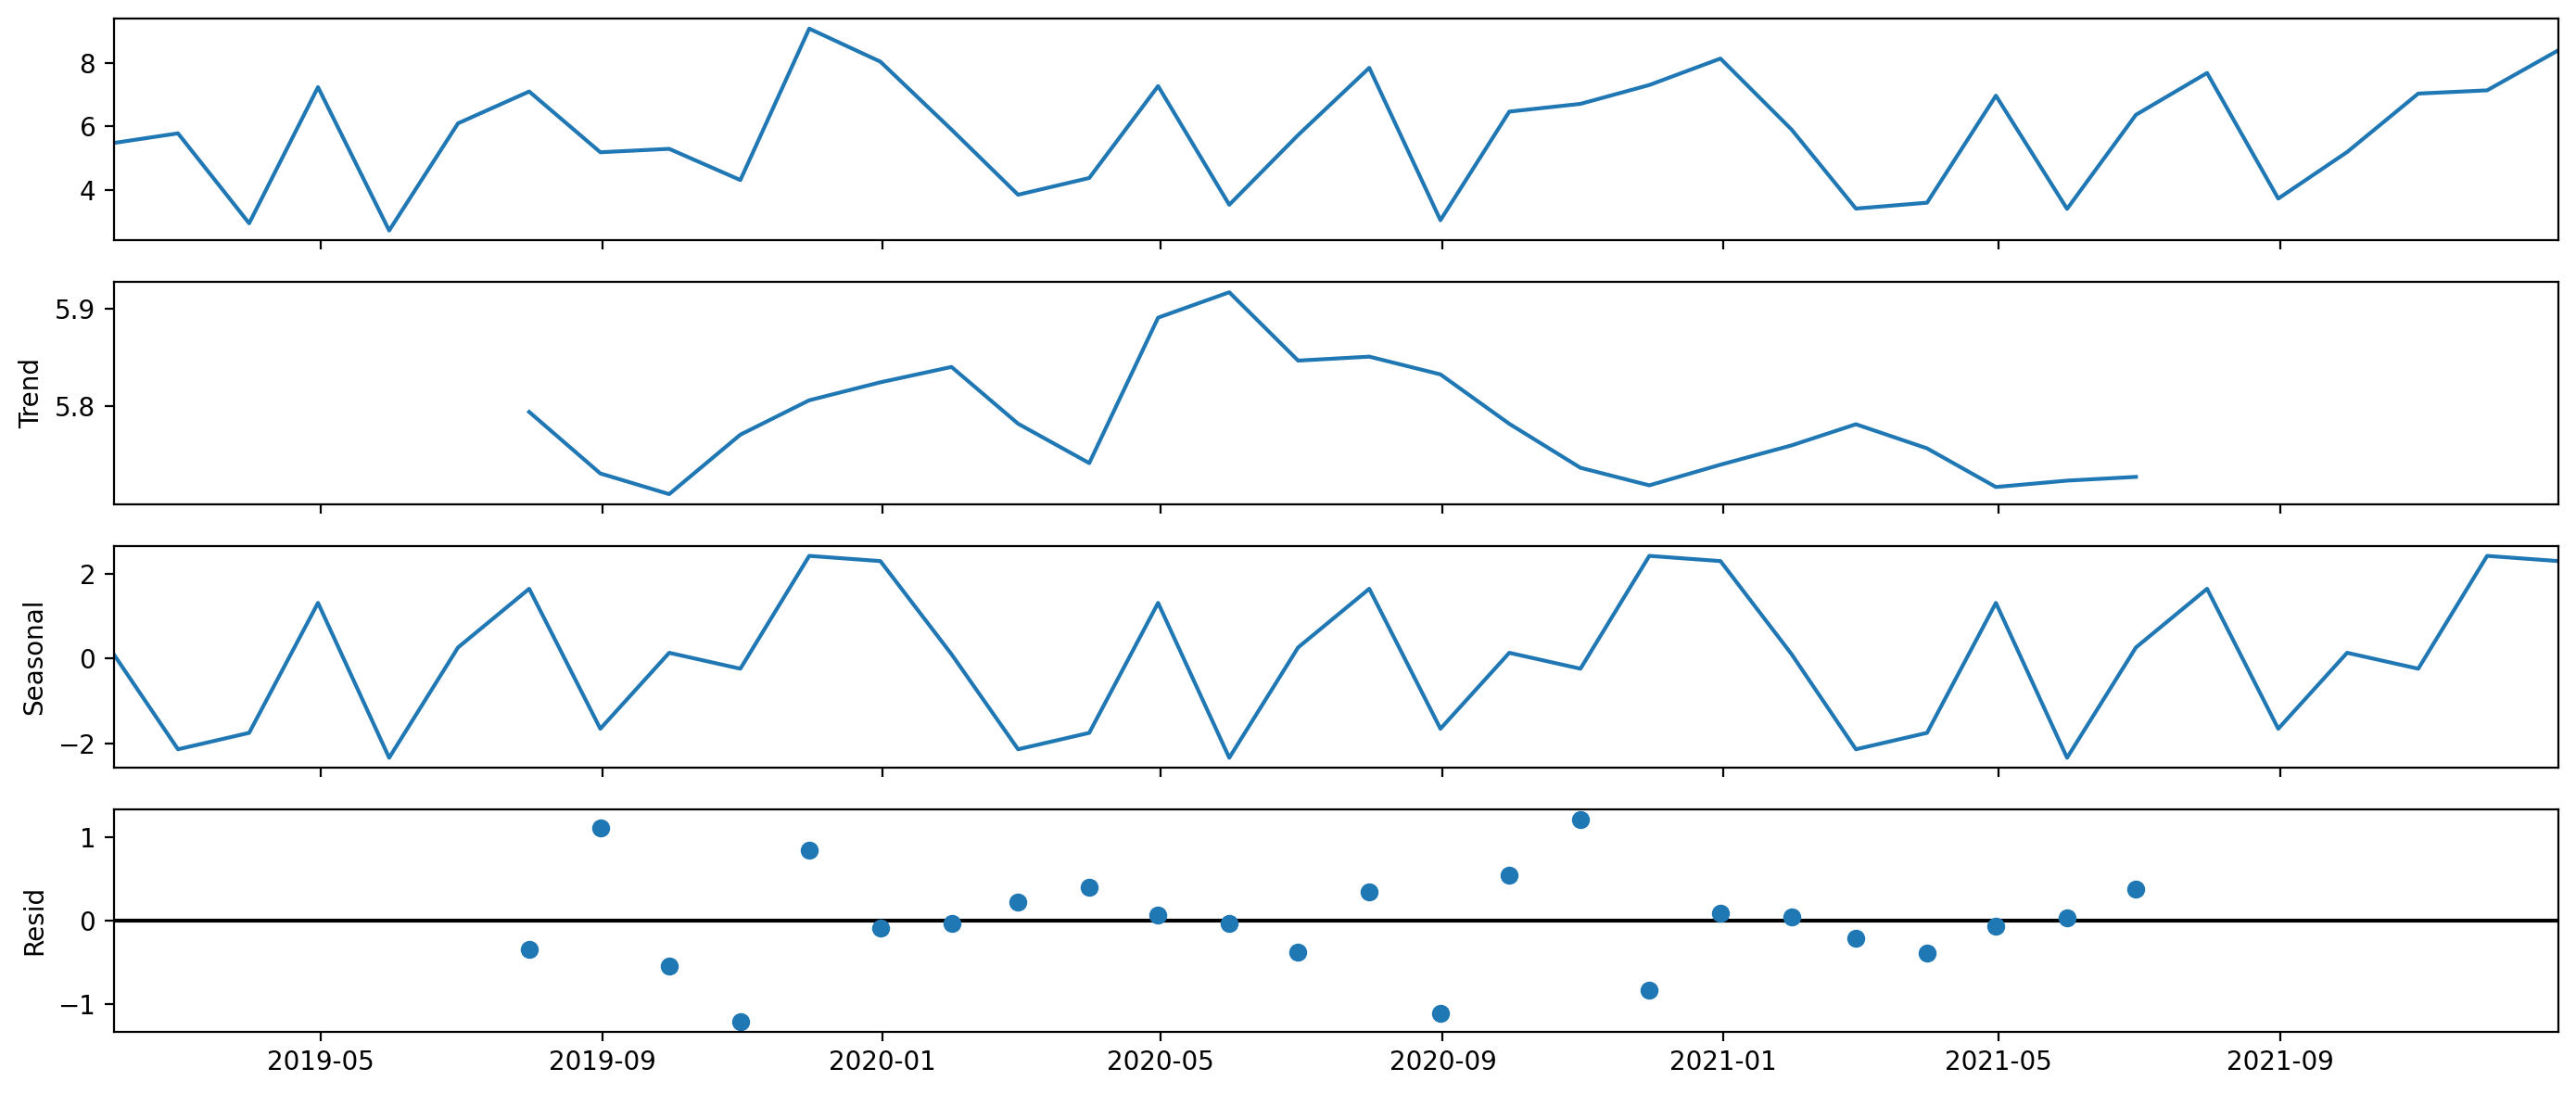

In [287]:
monthly_decompose = seasonal_decompose(monthly_sales.set_index('date'))
monthly_decompose.plot();

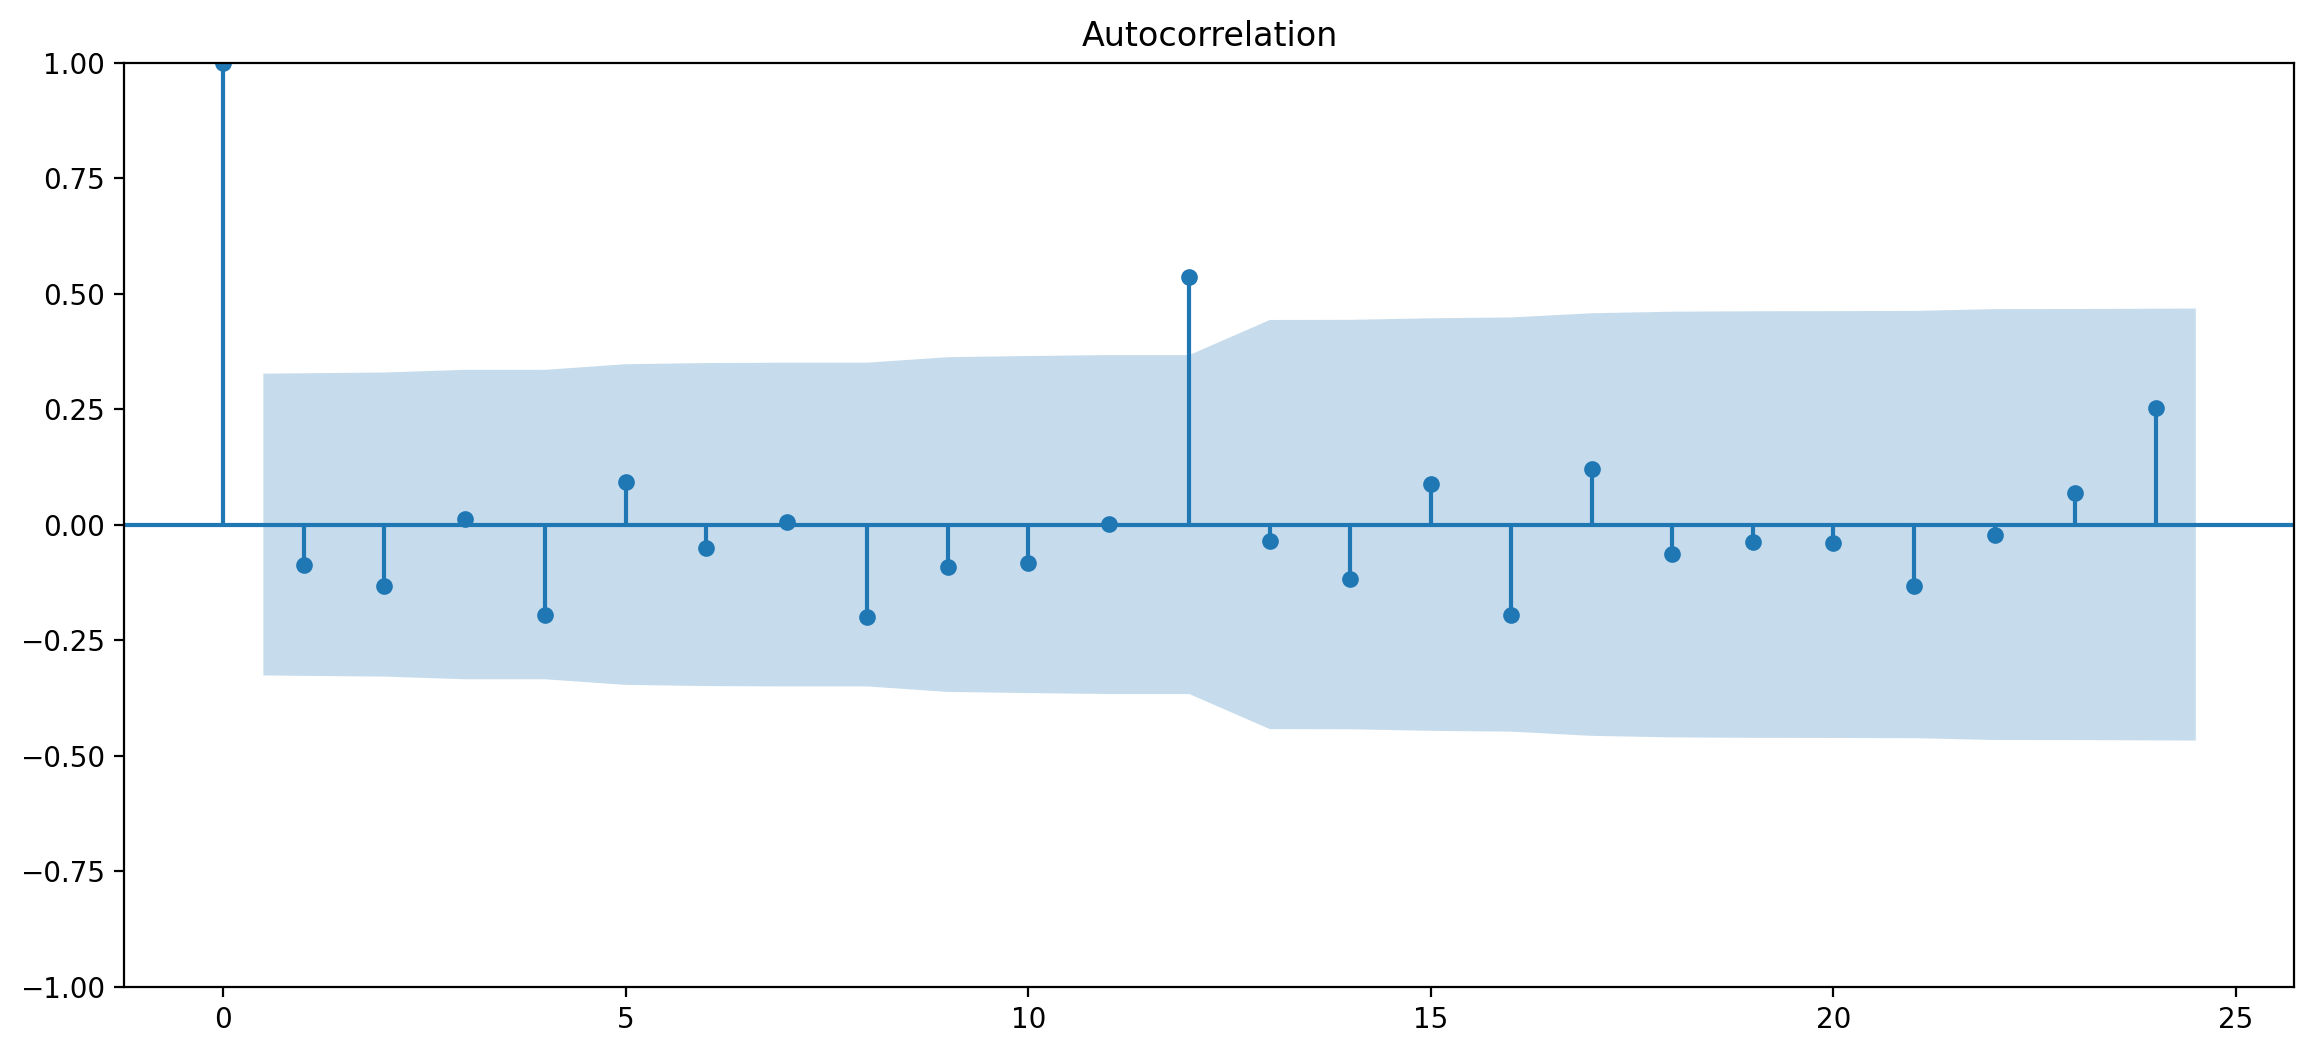

In [288]:
sm.graphics.tsa.plot_acf(monthly_sales.product_sales.squeeze(), lags=12*2);